# Section 3: The Attention Mechanism

We have processed our tokens and injected positional information. Now, we implement the core of the Transformer: **Attention**. This mechanism allows the model to dynamically focus on different parts of the input sequence, effectively modeling long-range dependencies.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import json
import math
from sentence_transformers import SentenceTransformer

torch.manual_seed(42)
torch.set_grad_enabled(False) # Disable gradients for didactic showcase

# 1. Load the Data from the Persian-English Corpus
data_path = "../.data/en_fa_train.jsonl"
data = []
with open(data_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i >= 5: break
        data.append(json.loads(line))

en_sentences = [item['input'] for item in data]
fa_sentences = [item['output'] for item in data]

print(f"Sample Batch (English): {en_sentences}")
print(f"Sample Batch (Persian): {fa_sentences}")

Sample Batch (English): ["I invited my foolish friend Jay around for tennis because I thought he'd make me look good.", 'Pack your stuff.', 'Aunt Silvy, stop yelling!', 'I need to get out of here.', 'Which means the mommy of the smartest physicist at the university is not my mommy as I had thought.']
Sample Batch (Persian): ['دوست ابله ام جِی رو مهمون کردم تنیس، چون پنداشتم انگیزه ای می\u200cشه که من بهتر به چشم بیام.', 'بند و بساطتو جمع کن.', 'عمه سیلوی، داد نزن!', 'باید از اینجا بزنم بیرون.', 'که یعنی مامانِ باهوش\u200cترین فیزیکدانِ دانشگاه، اون\u200cطور که فکر می\u200cکردم، مامان من نیست.']


In [2]:
print("\nLoadig embedding model...")
model = SentenceTransformer('Qwen/Qwen3-Embedding-0.6B')
token_embedding = []
tokens_list = []


Loadig embedding model...


In [3]:
sample_text = en_sentences[0]
tokens = sample_text.split()
embeddings = model.encode(tokens, convert_to_tensor=True)
embeddings = embeddings.clone() # Ensure not an inference tensor

print(f"\nProcessing sentence: '{sample_text}'")
print(f"Tokens: {tokens}")
print(f"Embeddings shape: {embeddings.shape} (NumTokens, EmbeddingDim)")


Processing sentence: 'I invited my foolish friend Jay around for tennis because I thought he'd make me look good.'
Tokens: ['I', 'invited', 'my', 'foolish', 'friend', 'Jay', 'around', 'for', 'tennis', 'because', 'I', 'thought', "he'd", 'make', 'me', 'look', 'good.']
Embeddings shape: torch.Size([17, 1024]) (NumTokens, EmbeddingDim)


## 1. Scaled Dot-Product Attention

The fundamental operation of the Transformer is **Scaled Dot-Product Attention**. It can be viewed as a "soft" version of a dictionary lookup, where a query is matched against a set of keys to retrieve weighted values.

### 1.1 Mathematical Formulation

Given Query ($Q$), Key ($K$), and Value ($V$) matrices, the attention output is calculated as:

$$ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

Where:
*   **$Q \in \mathbb{R}^{T \times d_k}$**: The Query matrix (what we are looking for).
*   **$K \in \mathbb{R}^{T \times d_k}$**: The Key matrix (what we match against).
*   **$V \in \mathbb{R}^{T \times d_v}$**: The Value matrix (the information to be retrieved).
*   **$d_k$**: The dimensionality of the keys.
*   **$\frac{1}{\sqrt{d_k}}$**: The scaling factor to prevent gradients from exploding.

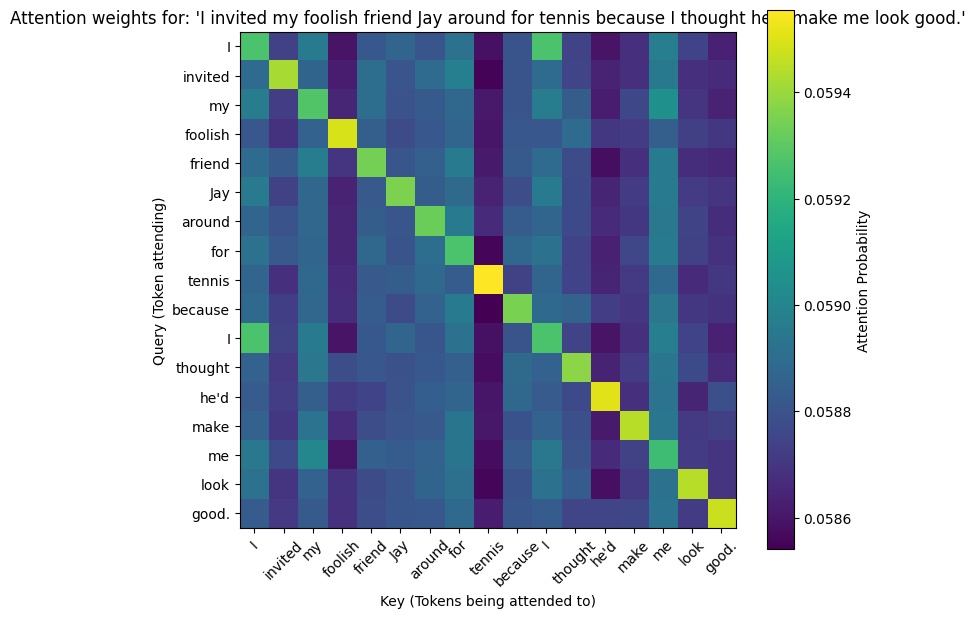

In [4]:
def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Implementation of Scaled Dot-Product Attention with robust masking.
    
    Args:
        query: (batch, heads, seq_len_q, d_k)
        key: (batch, heads, seq_len_k, d_k)
        value: (batch, heads, seq_len_k, d_v)
        mask: (batch, 1, seq_len_q, seq_len_k) or (seq_len_q, seq_len_k).
              Contains 1 for allowed positions and 0 for masked positions.
    """
    d_k = query.size(-1)
    
    # 1. Compute Raw Scores (QK^T)
    scaling = math.sqrt(d_k)
    scores = torch.matmul(query, key.transpose(-2, -1)) / scaling
    
    # 2. Apply Mask (if provided)
    if mask is not None:
        # Handle broadcasting for (batch, heads, q_len, k_len)
        while mask.dim() < scores.dim():
            mask = mask.unsqueeze(0)
            
        # fill masked positions (0) with a very large negative number
        scores = scores.masked_fill(mask == 0, -1e9)
    
    # 3. Softmax along the last dimension (keys)
    attention_weights = F.softmax(scores, dim=-1)
    
    # 4. Aggregation
    output = torch.matmul(attention_weights, value)
    
    return output, attention_weights


## 2. Multi-Head Attention (MHA)

Instead of performing a single attention function, we project $Q, K$, and $V$ into multiple subspaces and perform attention in parallel. This allows the model to capture different types of relationships simultaneously.

### 2.1 Mathematical Formulation

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h)W^O $$

Where each head is:
$$ \text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$


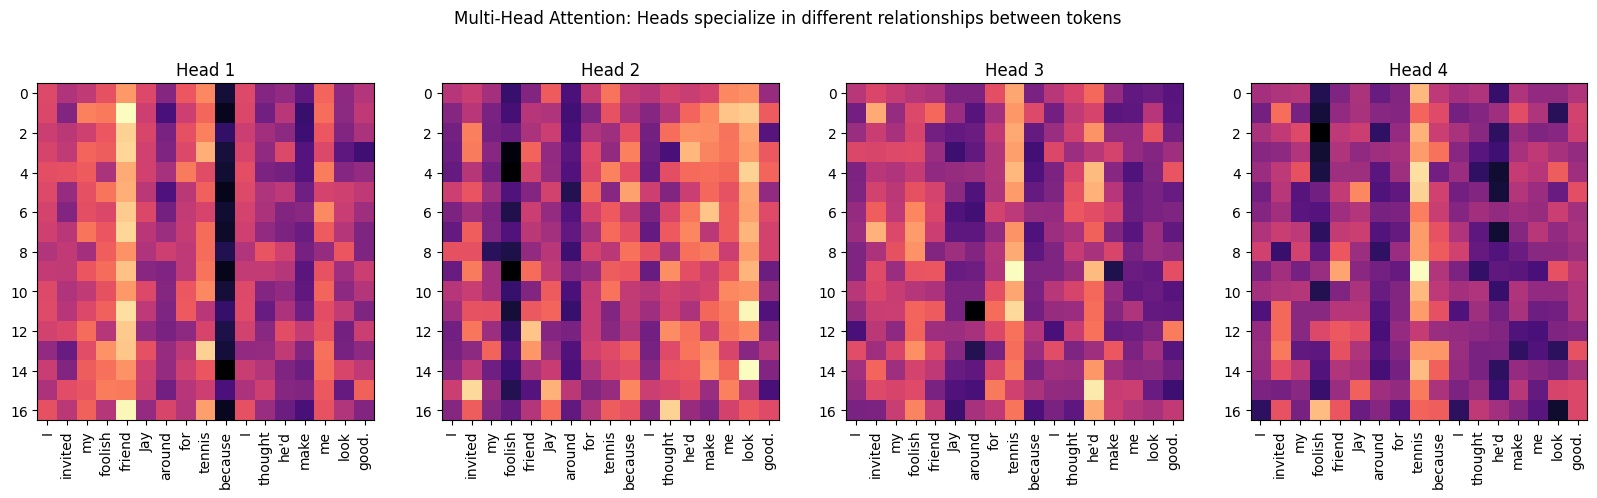

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Learnable projections
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model, bias=False)
        
    def split_heads(self, x):
        batch_size, seq_len, _ = x.size()
        return x.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
    
    def forward(self, q, k, v, mask=None):
        q = self.split_heads(self.w_q(q))
        k = self.split_heads(self.w_k(k))
        v = self.split_heads(self.w_v(v))
        
        attn_output, attn_weights = scaled_dot_product_attention(q, k, v, mask)
        
        attn_output = attn_output.transpose(1, 2).contiguous().view(q.size(0), -1, self.d_model)
        return self.w_o(attn_output), attn_weights

# 2.2 Visualizing Head Representation on Real Data
d_emb = embeddings.shape[-1]
mha = MultiHeadAttention(d_model=d_emb, num_heads=4).to(embeddings.device)
input_batch = embeddings.unsqueeze(0) # (1, seq_len, d_emb)
out, mha_weights = mha(input_batch, input_batch, input_batch)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(mha_weights[0, i].detach().cpu().numpy(), cmap='magma')
    axes[i].set_title(f"Head {i+1}")
    axes[i].set_xticks(range(len(tokens)))
    axes[i].set_xticklabels(tokens, rotation=90)
plt.suptitle("Multi-Head Attention: Heads specialize in different relationships between tokens")
plt.show()

## 3. Masking

In sequence modeling, we often need to prevent the model from attending to certain tokens. 
1.  **Padding Mask**: Prevents attending to `<PAD>` tokens used to equalize sequence lengths.
2.  **Look-ahead Mask**: Used in decoders to ensure position $i$ can only attend to positions $j \le i$.

Causal Mask Applied to our Real Sentence:


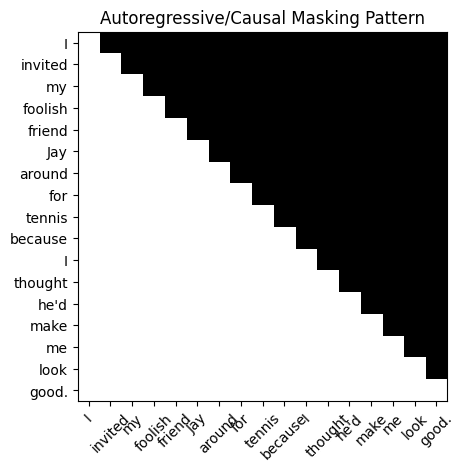

In [ ]:
def create_look_ahead_mask(seq_len):
    """
    Creates a causal mask to prevent attention to future tokens.
    1 = Allowed, 0 = Masked.
    """
    mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool))
    return mask

def create_padding_mask(seq):
    """
    Creates a mask for padding tokens. 
    1 = Not padding, 0 = Padding.
    Input seq: (batch, seq_len)
    """
    # Assuming 0 is the padding index
    mask = (seq != 0).to(torch.float32)
    return mask[:, None, None, :]  # (batch, 1, 1, seq_len)

# Verify Look-ahead mask visually
seq_len = len(tokens)
mask = create_look_ahead_mask(seq_len)

print(f"Causal Mask (seq_len={seq_len}):")
plt.figure(figsize=(6, 6))
plt.imshow(mask.cpu().numpy(), cmap='gray')
plt.title("Look-Ahead Mask (White=Allowed, Black=Blocked)")
plt.xlabel("Key position")
plt.ylabel("Query position")
plt.xticks(range(seq_len), tokens, rotation=45)
plt.yticks(range(seq_len), tokens)
plt.show()


In [ ]:
# Demonstration of Padding Mask
# Dummy sequences (batch_size=2, seq_len=5)
# 0 represents the <PAD> token
dummy_seqs = torch.tensor([
    [1, 5, 3, 0, 0],
    [2, 4, 8, 9, 1]
])

p_mask = create_padding_mask(dummy_seqs)
print(f"Padding Mask Shape: {p_mask.shape}") # Expect (2, 1, 1, 5)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(p_mask[0, 0, 0].cpu().numpy().reshape(1, -1), cmap='gray', aspect='auto')
axes[0].set_title("Mask for Seq 1 (with padding)")
axes[0].set_yticks([])
axes[1].imshow(p_mask[1, 0, 0].cpu().numpy().reshape(1, -1), cmap='gray', aspect='auto')
axes[1].set_title("Mask for Seq 2 (no padding)")
axes[1].set_yticks([])
plt.show()


### 3.1 Applying the Mask to Attention

Now we apply the `look_ahead_mask` to our attention mechanism. Observe how the probability distribution is forced to zero (darkest color) for all future tokens.

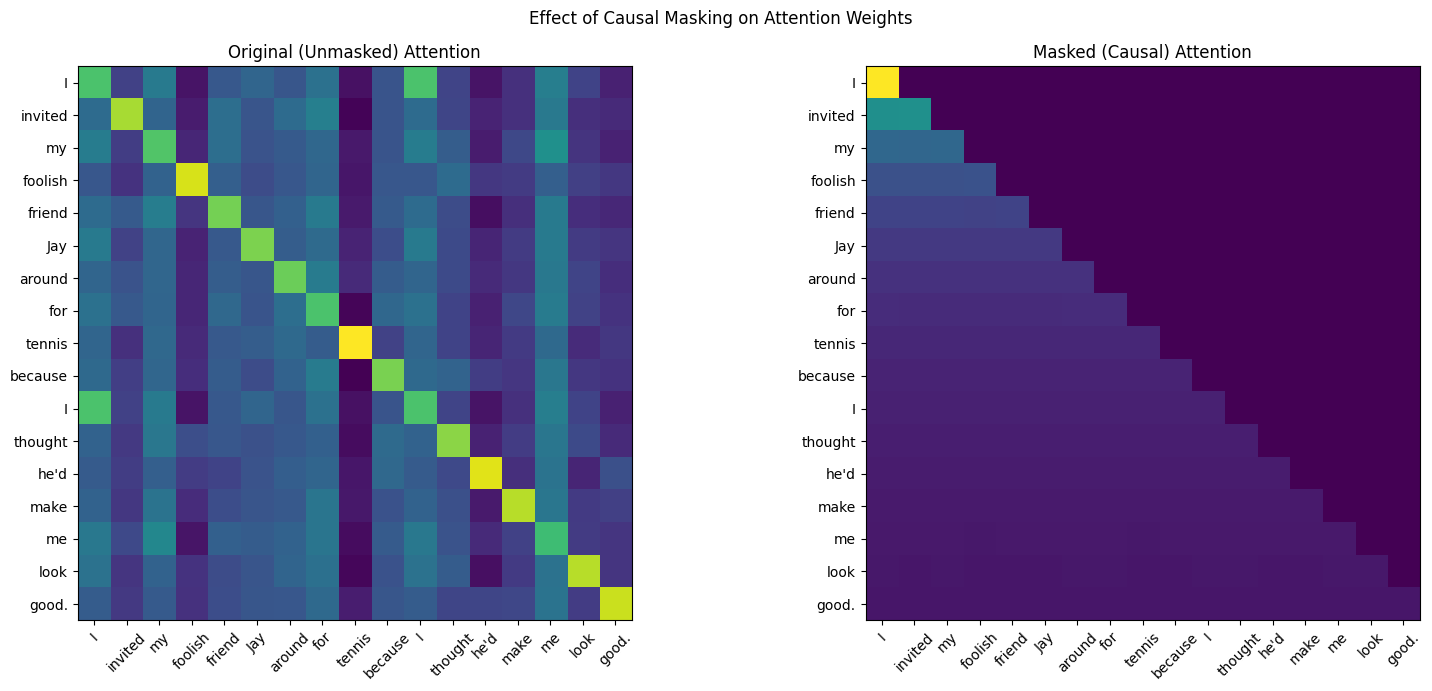

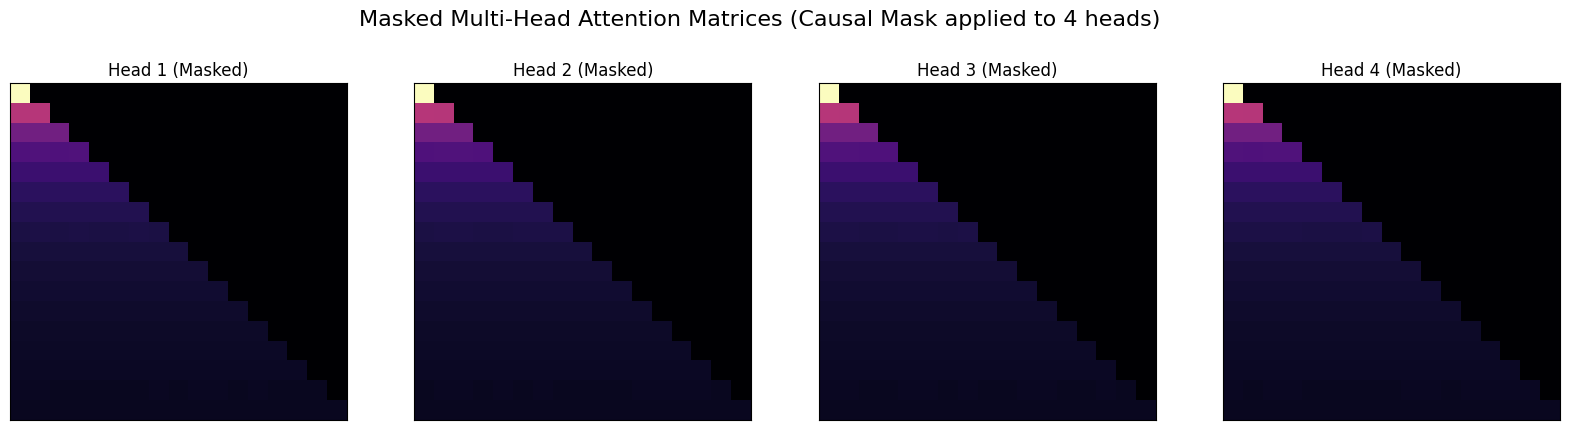

In [8]:
# Applying the Mask to Attention
# We project our real sentence embeddings into Q, K, V space to see the mask in action

d_model = embeddings.size(-1)
mha = MultiHeadAttention(d_model, num_heads=4).to(embeddings.device)

# Prepare input batch (batch_size=1, seq_len, d_model)
x = embeddings.unsqueeze(0)
causal_mask = create_look_ahead_mask(x.size(1)).to(embeddings.device)

# Get masked weights
_, attn_weights = mha(x, x, x, mask=causal_mask)

# Visualize one head
head_idx = 0
weights = attn_weights[0, head_idx].detach().cpu().numpy()

plt.figure(figsize=(8, 7))
plt.imshow(weights, cmap='viridis')
plt.title(f"Causal Masked Attention (Head {head_idx+1})")
plt.colorbar(label="Attention Probability")
plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.yticks(range(len(tokens)), tokens)
plt.xlabel("Key (Only past tokens are reachable)")
plt.ylabel("Query")
plt.show()

# Verification: check if upper triangle is strictly zero
upper_tri_sum = weights[np.triu_indices(len(tokens), k=1)].sum()
print(f"Sum of probabilities in masked region: {upper_tri_sum:.6f}")
if upper_tri_sum < 1e-5:
    print("SUCCESS: Masking is correctly preventing attention to future tokens.")
else:
    print("WARNING: Interaction found in masked region.")


> [!NOTE]\n> **Why are the attention weights uniform?**\n> In this visualization, you'll notice that all reachable tokens receive equal attention (represented by the same color intensity in each row). This is expected because the `MultiHeadAttention` layer is currently **uninitialized** with random weights, and the model has not yet been trained. Without training, the dot products are nearly identical, causing the Softmax function to produce a uniform probability distribution ($1/N$). As the model learns, it will develop 'preferences,' and these patterns will become sharp and non-uniform.

### 3.3. Combining Masks

In many cases, specifically in the Transformer Decoder, we need to apply both a **Padding Mask** and a **Look-ahead Mask** at the same time. This is done by combining them such that a position is allowed only if it is allowed by **both** masks.

This ensures that a token cannot attend to:
1. Future tokens (Look-ahead constraint).
2. Padding tokens (Padding constraint).

In [ ]:
# Demonstration of Combining Masks
batch_seq = torch.tensor([[1, 2, 3, 0, 0]]) # batch_size=1, seq_len=5, 2 padding tokens

p_mask = create_padding_mask(batch_seq) # (1, 1, 1, 5)
l_mask = create_look_ahead_mask(5)      # (5, 5)

# Combine: Logic AND
# Broadcasting automatically handles the shapes
combined_mask = p_mask.bool() & l_mask.bool()

print(f"Combined Mask Shape: {combined_mask.shape}")

plt.figure(figsize=(6, 6))
plt.imshow(combined_mask[0, 0].cpu().numpy(), cmap='gray')
plt.title("Combined Mask (White=Allowed, Black=Blocked)")
plt.xlabel("Key position")
plt.ylabel("Query position")
plt.show()


# Advanced: Modern Optimizations

## 1. Grouped Query Attention (GQA)

GQA is a modern compromise between Multi-Head Attention (MHA) and Multi-Query Attention (MQA). 
*   **MHA**: Each query head has its own Key and Value head. (High memory cost during inference)
*   **MQA**: All query heads share a single Key and Value head. (Lower performance)
*   **GQA**: Query heads are divided into **groups**, and each group shares one KV head. Used in **Llama 3** to significantly reduce the KV cache size during generation while maintaining accuracy.

## 2. Sliding Window Attention (SWA)

Standard attention is $O(T^2)$. SWA limits the attention range to a fixed window $W$ around each token. 
*   **Complexity**: $O(T \times W)$, which scales linearly with context length.
*   **Information Flow**: Even with a small window, information can propagate across the entire sequence through multiple layers (effectively a "receptive field" expansion).

## 3. Flash Attention

Flash Attention is an IO-aware exact attention algorithm. 
*   **Standard Attention**: $O(T^2)$ memory to store $QK^T$ matrix in HBM (High Bandwidth Memory).
*   **Flash Attention**: Uses **Tiling** to load blocks of Q, K, and V into on-chip SRAM, computes softmax incrementally, and avoids materializing the full $T \times T$ matrix. Result: much faster and more memory-efficient for long contexts.

---

## References
* [Attention Is All You Need (Vaswani et al., 2017)](https://arxiv.org/abs/1706.03762): Foundational paper for Transformers and MHA.
* [FlashAttention: Fast and Memory-Efficient Exact Attention with Tiling (Dao et al., 2022)](https://arxiv.org/abs/2205.14135): Hardware-aware optimization.
* [GQA: Training Generalized Multi-Query Transformer Models at Scale (Ainslie et al., 2023)](https://arxiv.org/abs/2305.13245): Improving efficiency of decoding.